In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

In [2]:
def fetch_data(stock, start_date, end_date):
    stock_data = yf.download(stock, start=start_date, end=end_date) # Download historical data from Yahoo Finance
    return stock_data

In [3]:
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
hsd = fetch_data(stock_symbol, start_date, end_date) #HSD = Historical stock data
print("\n\n\n\n")
print(hsd.head())
print("\n\n\n\n")

[*********************100%%**********************]  1 of 1 completed





                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.152657  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.441467  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  73.018692  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.675285  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.844360  132079200







In [4]:

def preprocess_data(data, num_lags=1):
    data = data.dropna()
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    for feature in numerical_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data[feature] = data[feature].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

    data = data.ffill().bfill()
    scaler = MinMaxScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    lag_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    for feature in lag_features:
        for i in range(1, num_lags + 1):
            col_name = f'{feature}_lag_{i}'
            data[col_name] = data[feature].shift(i)

    # Drop rows with missing values created by lag features
    data = data.dropna()

    return data

psd = preprocess_data(hsd, num_lags=1)



In [5]:
#psd = preprocess_data(hsd) # psd = preprocessed_stock_data
print("\n\n\n\n")
print("Before Preprocessing:")
print(hsd.describe())
print("\nAfter Preprocessing:")
print(psd.describe())
print("\n\n\n\n")






Before Preprocessing:
             Open        High         Low       Close   Adj Close  \
count  756.000000  756.000000  756.000000  756.000000  756.000000   
mean   130.231998  131.892775  128.614983  130.311812  128.567774   
std     30.596429   30.841435   30.287325   30.566496   30.644242   
min     57.020000   57.125000   53.152500   56.092499   54.776806   
25%    115.924374  117.275000  114.129997  115.739374  113.534901   
50%    135.794998  137.200005  133.750000  135.379997  133.984833   
75%    150.259998  151.902504  149.029995  150.704998  149.306957   
max    182.630005  182.940002  179.119995  182.009995  179.953888   

             Volume  
count  7.560000e+02  
mean   1.120920e+08  
std    5.602586e+07  
min    3.519590e+07  
25%    7.636470e+07  
50%    9.493580e+07  
75%    1.296327e+08  
max    4.265100e+08  

After Preprocessing:
             Open        High         Low       Close   Adj Close      Volume  \
count  755.000000  755.000000  755.000000  755.000

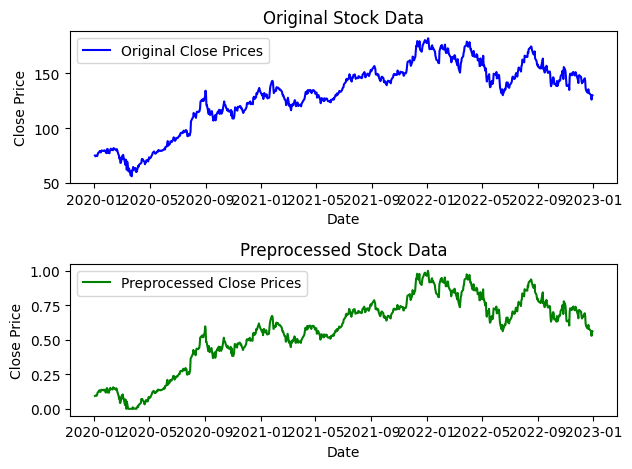

In [6]:
plt.subplot(2, 1, 1)
plt.plot(hsd.index, hsd['Close'], label='Original Close Prices', color='blue')
plt.title('Original Stock Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot preprocessed 'Close' prices
plt.subplot(2, 1, 2)
plt.plot(psd.index, psd['Close'], label='Preprocessed Close Prices', color='green')
plt.title('Preprocessed Stock Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
def feature_selection(data):
    correlation_matrix = data.corr()  # Calculate correlation matrix
    correlation_threshold = 0.9      # Set a correlation threshold

    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    #to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
   #data = data.drop(to_drop, axis=1)

    print("Columns after dropping correlated features:", data.columns)

    # Check if 'Close' column exists before dropping
    if 'Close' in data.columns:
        # Feature importance using RandomForestRegressor
        X = data.drop('Close', axis=1)
        y = data['Close']

        model = RandomForestRegressor()
        model.fit(X, y)

        # Display feature importances
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_importances = feature_importances.sort_values(ascending=False)

        # Visualize feature importances
        plt.figure(figsize=(10, 6))
        feature_importances.plot(kind='bar')
        plt.title('Feature Importances')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.show()

        # Select the top N features
        top_features = feature_importances[:5].index
        selected_data = data[list(top_features) + ['Close']]

        print("Columns after feature selection:", selected_data.columns)
        return selected_data
    else:
        print("The 'Close' column is not present in the DataFrame.")
        return data


Columns after dropping correlated features: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Open_lag_1',
       'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Volume_lag_1'],
      dtype='object')


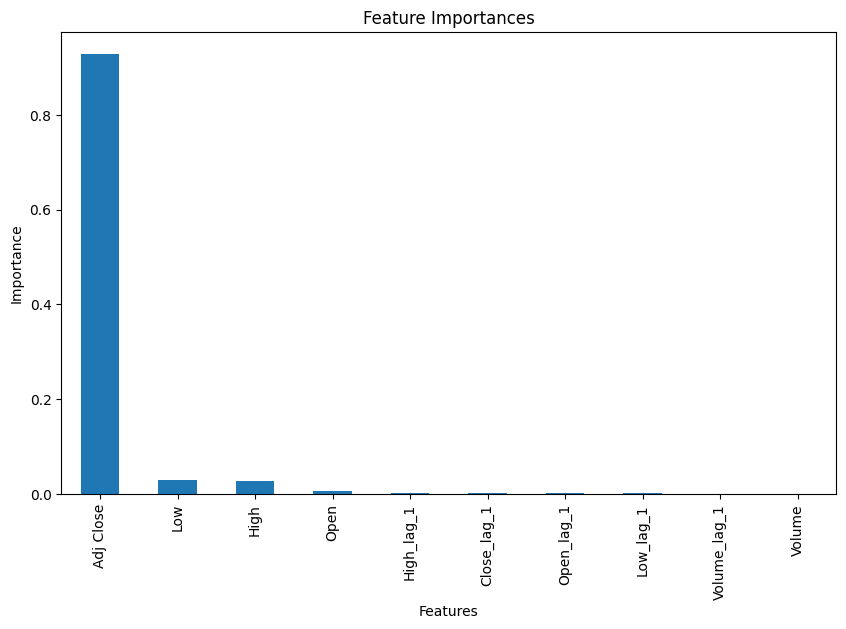

Columns after feature selection: Index(['Adj Close', 'Low', 'High', 'Open', 'High_lag_1', 'Close'], dtype='object')
            Adj Close       Low      High      Open  High_lag_1     Close
Date                                                                     
2020-01-03  72.441467  0.105207  0.083425  0.083467    0.083467  0.093216
2020-01-06  73.018692  0.097217  0.082107  0.076361    0.083425  0.098207
2020-01-07  72.675285  0.107295  0.084105  0.089156    0.082107  0.095238
2020-01-08  73.844360  0.106613  0.091630  0.083488    0.084105  0.105346
2020-01-09  75.412880  0.125874  0.104363  0.104806    0.091630  0.118907


In [8]:
selected_data = feature_selection(psd)
print(selected_data.head())

In [9]:
def train_test_split_chrono(data, test_size=0.2):
    sorted_data = data.sort_index()  # Sort the data chronologically
    split_index = int(len(sorted_data) * (1 - test_size))
    train_data, test_data = sorted_data.iloc[:split_index], sorted_data.iloc[split_index:]
    return train_data, test_data

Training set shape: (604, 6)
Testing set shape: (151, 6)


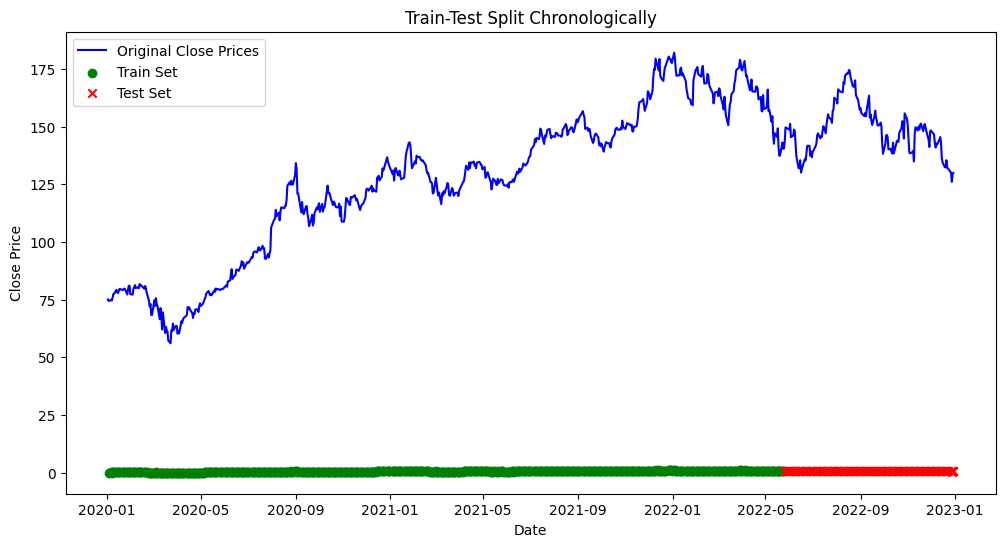

In [10]:
train_data, test_data = train_test_split_chrono(selected_data, test_size=0.2)
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)
plt.figure(figsize=(12, 6))

plt.plot(hsd.index, hsd['Close'], label='Original Close Prices', color='blue')

plt.scatter(train_data.index, train_data['Close'], label='Train Set', color='green', marker='o') # Highlight train set
plt.scatter(test_data.index, test_data['Close'], label='Test Set', color='red', marker='x') # Highlight test set

plt.title('Train-Test Split Chronologically')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [11]:
def train_evaluate_svm_model(train_data, test_data):
    # Feature scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_data.drop('Close', axis=1))
    y_train = train_data['Close'].values
    X_test = scaler.transform(test_data.drop('Close', axis=1))
    y_test = test_data['Close'].values

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1]
    }

    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Train the final SVR model with the best hyperparameters
    final_svr_model = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])
    final_svr_model.fit(X_train, y_train)

    # Make predictions on the test set
    svm_predictions = final_svr_model.predict(X_test)

    # Evaluate the model
    mse_svm = mean_squared_error(y_test, svm_predictions)
    rmse_svm = np.sqrt(mse_svm)
    mae_svm = mean_absolute_error(y_test, svm_predictions)

    # Plot the predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, y_test, label='Actual Close Price', marker='o')
    plt.plot(test_data.index, svm_predictions, label='Predicted Close Price', marker='x')
    plt.title('Actual vs Predicted Close Price (SVM)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    return svm_predictions, mse_svm, rmse_svm, mae_svm , final_svr_model

In [12]:
def train_evaluate_rf_model(train_data, test_data):
    # Feature scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_data.drop('Close', axis=1))
    y_train = train_data['Close'].values
    X_test = scaler.transform(test_data.drop('Close', axis=1))
    y_test = test_data['Close'].values

    # Hyperparameter tuning using GridSearchCV for Random Forest Regression
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_regressor = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Train the final Random Forest Regression model with the best hyperparameters
    final_rf_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    final_rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    rf_predictions = final_rf_model.predict(X_test)

    # Evaluate the model
    mse_rf = mean_squared_error(y_test, rf_predictions)
    rmse_rf = np.sqrt(mse_rf)
    mae_rf = mean_absolute_error(y_test, rf_predictions)
    
    #print(f'Mean Squared Error on the test set: {mse_rf}')

    # Plot the predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, y_test, label='Actual Close Price', marker='o')
    plt.plot(test_data.index, rf_predictions, label='Predicted Close Price', marker='x')
    plt.title('Actual vs Predicted Close Price (Random Forest)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    return rf_predictions, mse_rf, rmse_rf, mae_rf , final_rf_model

In [13]:
def create_ensemble_model(svm_predictions, rf_predictions, true_values):
    ensemble_model = VotingRegressor(estimators=[
        ('svm', SVR()), ('random_forest', RandomForestRegressor())
    ])
    
    # Stack predictions horizontally to create input for ensemble model
    ensemble_input = np.column_stack((svm_predictions, rf_predictions))
    
    # Train the ensemble model
    ensemble_model.fit(ensemble_input, true_values)
    
    # Make predictions using the ensemble model
    ensemble_predictions = ensemble_model.predict(ensemble_input)
    
    # Calculate evaluation metrics for the ensemble model
    mse_ensemble = mean_squared_error(true_values, ensemble_predictions)
    rmse_ensemble = np.sqrt(mse_ensemble)
    mae_ensemble = mean_absolute_error(true_values, ensemble_predictions)
    
    return ensemble_predictions, mse_ensemble, rmse_ensemble, mae_ensemble , ensemble_model

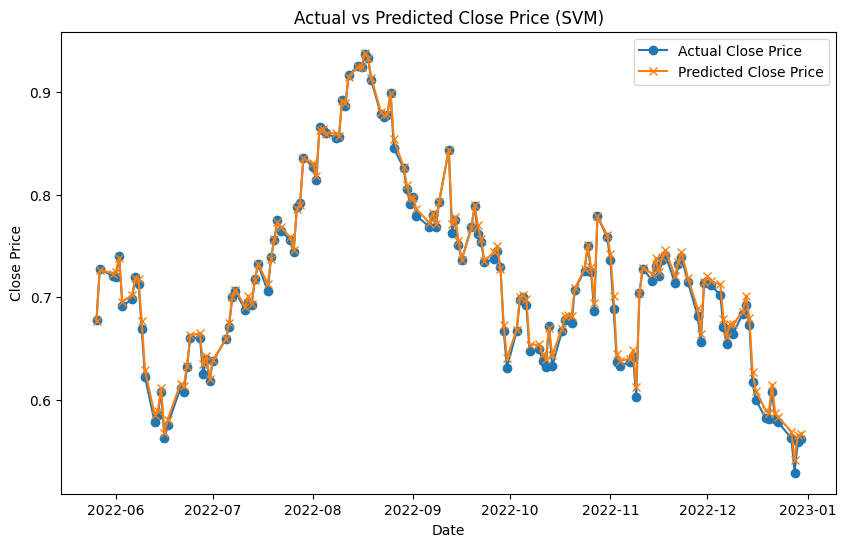

Mean Squared Error on the test set: 4.605760265778005e-05


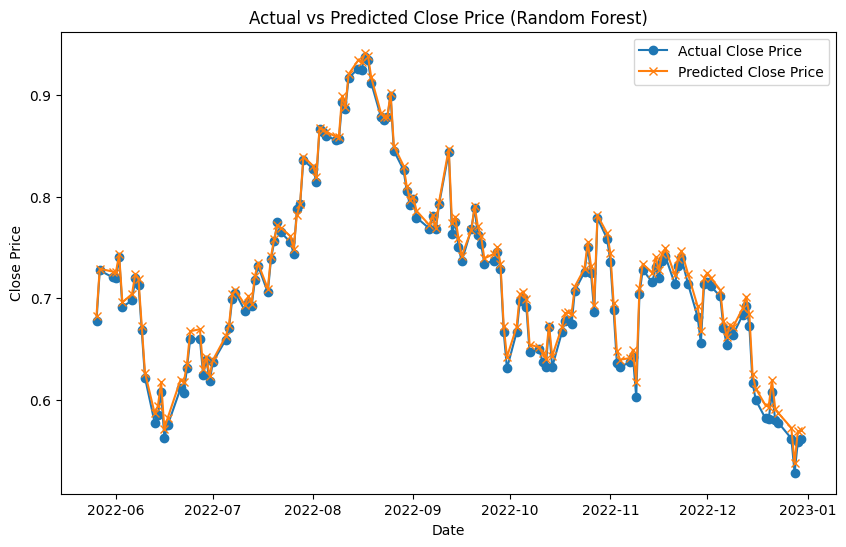

In [14]:
# Train and evaluate SVM model
svm_predictions, mse_svm, rmse_svm, mae_svm , final_svm_model = train_evaluate_svm_model(train_data, test_data)
# Train and evaluate RandomForestRegressor model
rf_predictions, mse_rf, rmse_rf, mae_rf , final_rf_model  = train_evaluate_rf_model(train_data, test_data)
# Create ensemble model
ensemble_predictions, mse_ensemble, rmse_ensemble, mae_ensemble , ensemble_model = create_ensemble_model(svm_predictions, rf_predictions, test_data['Close'])



In [15]:
# Compare performance
print("SVM Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_svm:.9e}')
print(f'Root Mean Squared Error (RMSE): {rmse_svm:.9e}')
print(f'Mean Absolute Error (MAE): {mae_svm:.9e}')
print("\n")

print("RandomForestRegressor Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_rf:.9e}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.9e}')
print(f'Mean Absolute Error (MAE): {mae_rf:.9e}')
print("\n")

# Evaluate ensemble model
print("Ensemble Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_ensemble:.9e}')
print(f'Root Mean Squared Error (RMSE): {rmse_ensemble:.9e}')
print(f'Mean Absolute Error (MAE): {mae_ensemble:.9e}')

SVM Model Evaluation:
Mean Squared Error (MSE): 2.510593726e-05
Root Mean Squared Error (RMSE): 5.010582527e-03
Mean Absolute Error (MAE): 4.036134870e-03


RandomForestRegressor Model Evaluation:
Mean Squared Error (MSE): 4.605760266e-05
Root Mean Squared Error (RMSE): 6.786575179e-03
Mean Absolute Error (MAE): 6.096947640e-03


Ensemble Model Evaluation:
Mean Squared Error (MSE): 7.770218279e-04
Root Mean Squared Error (RMSE): 2.787511126e-02
Mean Absolute Error (MAE): 2.423062957e-02


[*********************100%%**********************]  1 of 1 completed
Columns after dropping correlated features: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Open_lag_1',
       'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Volume_lag_1'],
      dtype='object')


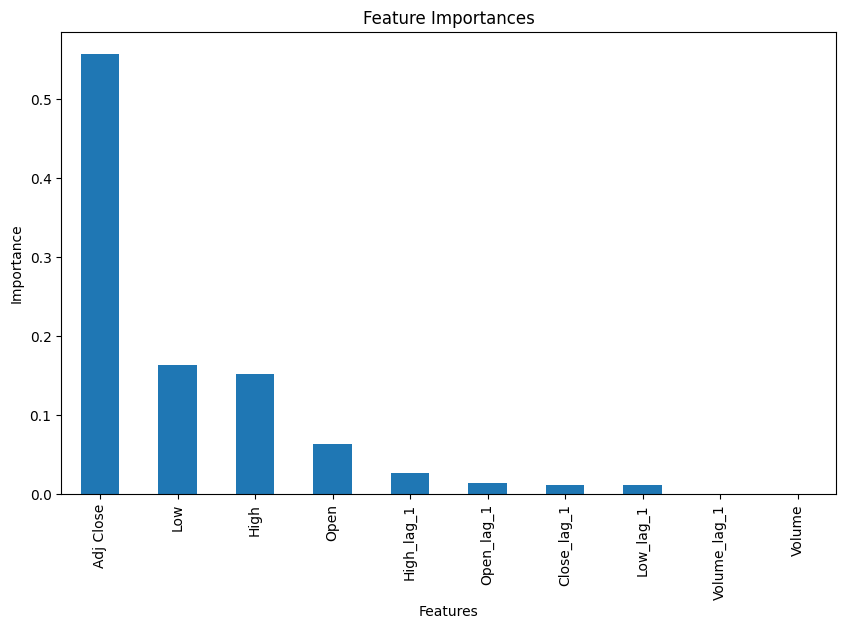

Columns after feature selection: Index(['Adj Close', 'Low', 'High', 'Open', 'High_lag_1', 'Close'], dtype='object')
SVM Model Evaluation on New Data:
Mean Squared Error (MSE): 1.376007869e-01
Root Mean Squared Error (RMSE): 3.709458004e-01
Mean Absolute Error (MAE): 3.325732065e-01


RandomForestRegressor Model Evaluation on New Data:
Mean Squared Error (MSE): 1.341952125e-01
Root Mean Squared Error (RMSE): 3.663266473e-01
Mean Absolute Error (MAE): 3.295092985e-01


Ensemble Model Evaluation on New Data:
Mean Squared Error (MSE): 8.184595503e-03
Root Mean Squared Error (RMSE): 9.046875429e-02
Mean Absolute Error (MAE): 7.362077862e-02






SVM Closing Price Predictions:
[0.34178704 0.26738055 0.30372209 0.34351053 0.18536107]

RandomForestRegressor Closing Price Predictions:
[0.36138269 0.31689489 0.34246464 0.34921629 0.21518103]

Ensemble Closing Price Predictions:
[0.63450131 0.63502031 0.63492141 0.63461673 0.63503799]





Printing the result.......



SVM Closing Price Predicti

In [48]:
# Download new data
new_data = fetch_data(stock_symbol, start_date='2023-01-02', end_date='2023-11-22')

# Preprocess the new data
new_psd = preprocess_data(new_data, num_lags=1)

# Feature selection
new_selected_data = feature_selection(new_psd)

# Split the new data into training and testing sets
new_train_data, new_test_data = train_test_split_chrono(new_selected_data, test_size=0.2)

# Feature scaling for SVM and RandomForestRegressor
scaler = MinMaxScaler()
X_new_test = scaler.fit_transform(new_test_data.drop('Close', axis=1))

# Make predictions using the trained SVM model
svm_new_predictions = final_svm_model.predict(X_new_test)

# Make predictions using the trained RandomForestRegressor model
rf_new_predictions = final_rf_model.predict(X_new_test)

# Create ensemble model
ensemble_input_new = np.column_stack((svm_new_predictions, rf_new_predictions))
ensemble_new_predictions = ensemble_model.predict(ensemble_input_new)

# Evaluate the models on the new data
mse_svm_new = mean_squared_error(new_test_data['Close'].values, svm_new_predictions)
rmse_svm_new = np.sqrt(mse_svm_new)
mae_svm_new = mean_absolute_error(new_test_data['Close'].values, svm_new_predictions)

mse_rf_new = mean_squared_error(new_test_data['Close'].values, rf_new_predictions)
rmse_rf_new = np.sqrt(mse_rf_new)
mae_rf_new = mean_absolute_error(new_test_data['Close'].values, rf_new_predictions)

mse_ensemble_new = mean_squared_error(new_test_data['Close'].values, ensemble_new_predictions)
rmse_ensemble_new = np.sqrt(mse_ensemble_new)
mae_ensemble_new = mean_absolute_error(new_test_data['Close'].values, ensemble_new_predictions)

# Print the evaluation metrics for the new data
print("SVM Model Evaluation on New Data:")
print(f'Mean Squared Error (MSE): {mse_svm_new:.9e}')
print(f'Root Mean Squared Error (RMSE): {rmse_svm_new:.9e}')
print(f'Mean Absolute Error (MAE): {mae_svm_new:.9e}')
print("\n")

print("RandomForestRegressor Model Evaluation on New Data:")
print(f'Mean Squared Error (MSE): {mse_rf_new:.9e}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_new:.9e}')
print(f'Mean Absolute Error (MAE): {mae_rf_new:.9e}')
print("\n")

# Evaluate ensemble model on new data
print("Ensemble Model Evaluation on New Data:")
print(f'Mean Squared Error (MSE): {mse_ensemble_new:.9e}')
print(f'Root Mean Squared Error (RMSE): {rmse_ensemble_new:.9e}')
print(f'Mean Absolute Error (MAE): {mae_ensemble_new:.9e}')

# Predictions for closing prices
svm_closing_predictions = svm_new_predictions
rf_closing_predictions = rf_new_predictions
ensemble_closing_predictions = ensemble_new_predictions
print("\n\n\n")
# Print the first few predictions
print("\n\nSVM Closing Price Predictions:")
print(svm_closing_predictions[:5])

print("\nRandomForestRegressor Closing Price Predictions:")
print(rf_closing_predictions[:5])

print("\nEnsemble Closing Price Predictions:")
print(ensemble_closing_predictions[:5])
print("\n\n\n")


# Reverse the scaling for SVM predictions
svm_closing_predictions_original_scale = svm_closing_predictions * (scaler.data_range_[4]) + scaler.data_min_[4]

# Reverse the scaling for RandomForestRegressor predictions
rf_closing_predictions_original_scale = rf_closing_predictions * (scaler.data_range_[4]) + scaler.data_min_[4]

# Reverse the scaling for Ensemble predictions
ensemble_closing_predictions_original_scale = ensemble_closing_predictions * (scaler.data_range_[4]) + scaler.data_min_[4]
print("\nPrinting the result.......\n\n")
# Print the original scale predictions
print("\nSVM Closing Price Predictions (Original Scale):")
print(svm_closing_predictions_original_scale[:5])

print("\nRandomForestRegressor Closing Price Predictions (Original Scale):")
print(rf_closing_predictions_original_scale[:5])

print("\nEnsemble Closing Price Predictions (Original Scale):")
print(ensemble_closing_predictions_original_scale[:5])


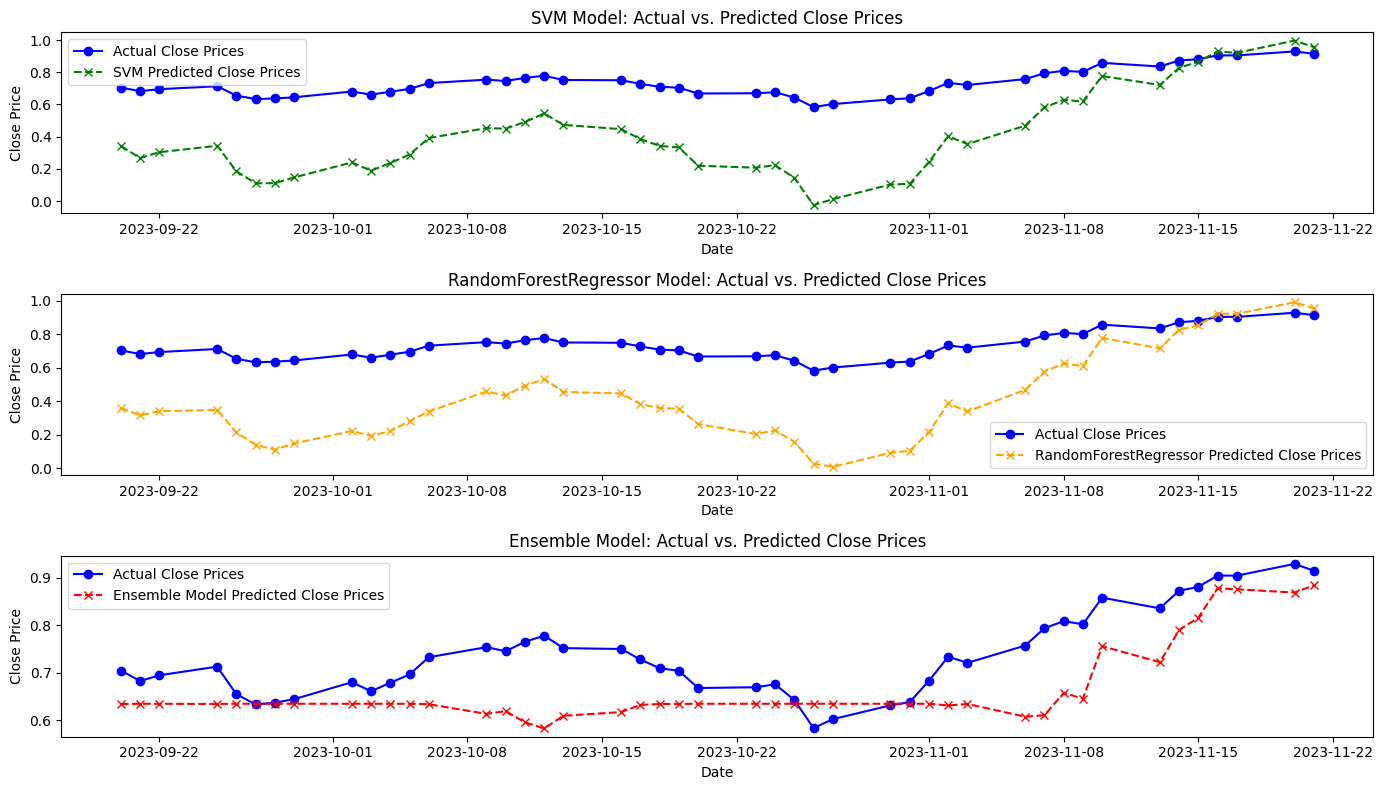

In [44]:
# Visualize Predictions vs. Actual Closing Prices
plt.figure(figsize=(14, 8))

# Plot SVM predictions
plt.subplot(3, 1, 1)
plt.plot(new_test_data.index, new_test_data['Close'], label='Actual Close Prices', marker='o', linestyle='-', color='blue')
plt.plot(new_test_data.index, svm_new_predictions, label='SVM Predicted Close Prices', marker='x', linestyle='--', color='green')
plt.title('SVM Model: Actual vs. Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot RandomForestRegressor predictions
plt.subplot(3, 1, 2)
plt.plot(new_test_data.index, new_test_data['Close'], label='Actual Close Prices', marker='o', linestyle='-', color='blue')
plt.plot(new_test_data.index, rf_new_predictions, label='RandomForestRegressor Predicted Close Prices', marker='x', linestyle='--', color='orange')
plt.title('RandomForestRegressor Model: Actual vs. Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot Ensemble Model predictions
plt.subplot(3, 1, 3)
plt.plot(new_test_data.index, new_test_data['Close'], label='Actual Close Prices', marker='o', linestyle='-', color='blue')
plt.plot(new_test_data.index, ensemble_new_predictions, label='Ensemble Model Predicted Close Prices', marker='x', linestyle='--', color='red')
plt.title('Ensemble Model: Actual vs. Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()


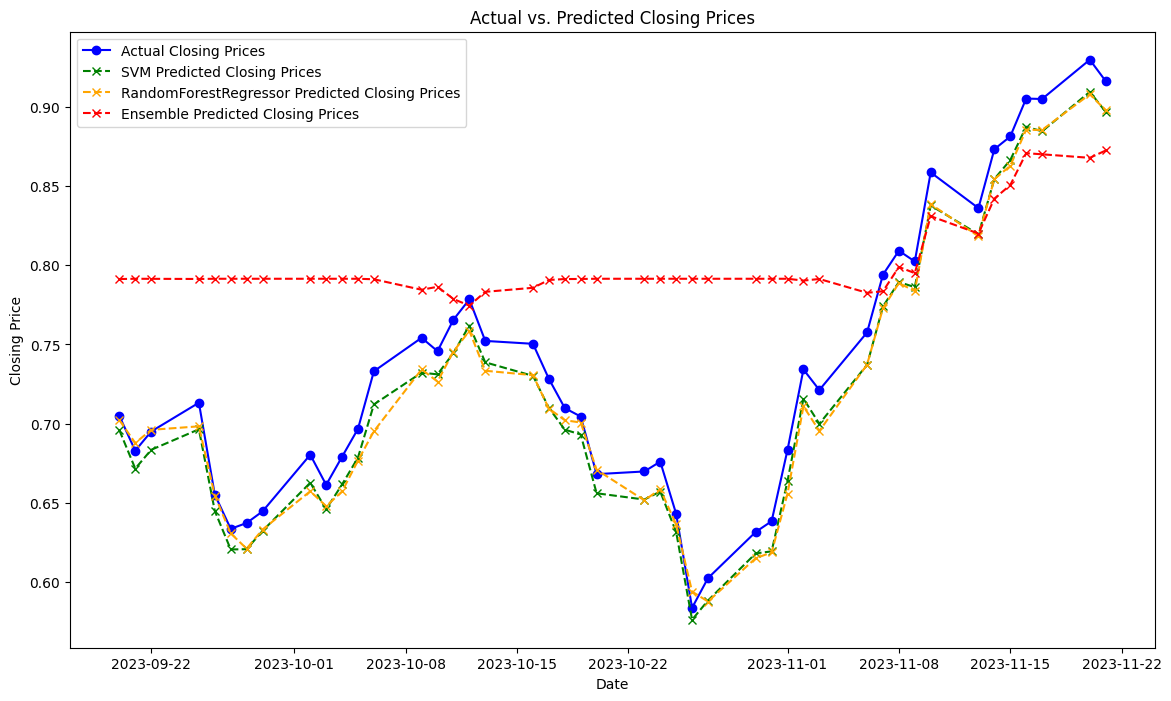

In [49]:

# Assuming new_test_data is the DataFrame containing the actual closing prices
actual_closing_prices = new_test_data['Close']

# Creating a DataFrame for the predicted closing prices
predictions_df = pd.DataFrame({
    'Date': new_test_data.index,
    'SVM Predictions': svm_closing_predictions_original_scale,
    'RandomForestRegressor Predictions': rf_closing_predictions_original_scale,
    'Ensemble Predictions': ensemble_closing_predictions_original_scale,
    'Actual Closing Prices': actual_closing_prices
})

# Setting the Date column as the index
predictions_df.set_index('Date', inplace=True)

# Plotting the actual vs. predicted closing prices
plt.figure(figsize=(14, 8))
plt.plot(predictions_df.index, predictions_df['Actual Closing Prices'], label='Actual Closing Prices', marker='o', linestyle='-', color='blue')
plt.plot(predictions_df.index, predictions_df['SVM Predictions'], label='SVM Predicted Closing Prices', marker='x', linestyle='--', color='green')
plt.plot(predictions_df.index, predictions_df['RandomForestRegressor Predictions'], label='RandomForestRegressor Predicted Closing Prices', marker='x', linestyle='--', color='orange')
plt.plot(predictions_df.index, predictions_df['Ensemble Predictions'], label='Ensemble Predicted Closing Prices', marker='x', linestyle='--', color='red')

plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
